In [1]:
# ライブラリのインストール＆インポート
!pip install arviz
import numpy as np
import pandas as pd
import pystan as pystan
from matplotlib import pyplot as plt
import arviz

     |████████████████████████████████| 1.6MB 8.6MB/s 
     |████████████████████████████████| 768kB 36.9MB/s 
     |████████████████████████████████| 4.7MB 39.2MB/s 
     |████████████████████████████████| 317kB 50.6MB/s 
  Found existing installation: xarray 0.15.1
    Uninstalling xarray-0.15.1:
      Successfully uninstalled xarray-0.15.1


In [47]:
# データの読み込み
files_path = '/content/drive/MyDrive/Analytics/Portfolio/Mahjong/'
df = pd.read_csv(files_path+'MahjongResults.csv')# 試合毎のプレーヤーの順位
df = df[df.index != 156]# 156番目の対局は欠損データがあるため除外
df

,ME,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O
0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0
1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0
2,3.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0
4,NaN,2.0,NaN,3.0,1.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0
152,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0
153,4.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
154,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0


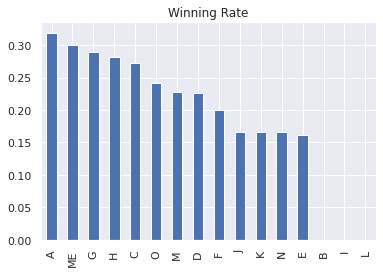

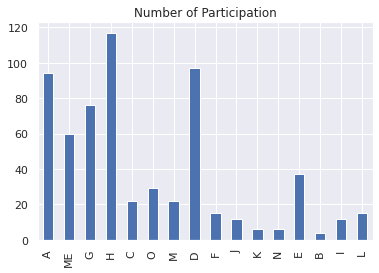

In [48]:
# 単純集計による1位率
df_summary = df.applymap(
    lambda x: np.nan if np.isnan(x) else x==1
).apply(
    lambda s: pd.Series({'winnig_rate': np.mean(s), 'num_battles': s.count()})
).pipe(
    lambda s: pd.DataFrame(s).T.sort_values(by='winnig_rate', ascending=False)
)

# 1位率
df_summary.winnig_rate.plot.bar()
plt.title('Winning Rate')
plt.show()

# 試合への参加回数
df_summary.num_battles.plot.bar()
plt.title('Number of Participation')
plt.show()

In [49]:
# stanのインプットデータ
df = df.pipe(
    lambda df: df[df_summary.index]
).assign(
    rank1 = lambda df: df.apply(lambda s: np.dot((s.iloc[:16]==1.0), np.array([ i+1 for i in range(16)])), axis=1),
    rank2 = lambda df: df.apply(lambda s: np.dot((s.iloc[:16]==2.0), np.array([ i+1 for i in range(16)])), axis=1),
    rank3 = lambda df: df.apply(lambda s: np.dot((s.iloc[:16]==3.0), np.array([ i+1 for i in range(16)])), axis=1),
    rank4 = lambda df: df.apply(lambda s: np.dot((s.iloc[:16]==4.0), np.array([ i+1 for i in range(16)])), axis=1)
)

data = {
    'N': df.shape[0],
    'M': 16,
    'rank1': df.rank1.to_numpy(),
    'rank2': df.rank2.to_numpy(),
    'rank3': df.rank3.to_numpy(),
    'rank4': df.rank4.to_numpy()
}

In [55]:
# モデルの定義
code = '''
data {
  int N;//試合数
  int M;//参加者数
  int rank1[N];//試合nにおける1位のプレーヤー番号
  int rank2[N];//試合nにおける2位のプレーヤー番号
  int rank3[N];//試合nにおける3位のプレーヤー番号
  int rank4[N];//試合nにおける4位のプレーヤー番号
}

parameters {
  simplex[M] winning_seeds;//プレーヤーの強さ
}

transformed parameters {
  real winning_rate[M];//平均値が0.25になるように調整したプレーヤーの強さ
  for (m in 1:M) {
    winning_rate[m] = winning_seeds[m] * M / 4;
  }
}

model {
  //試合nに参加したプレーヤーの勝率期待値の算出（以下のように定義）
  // -> 対象プレーヤーの勝率期待値 = 対象プレーヤーの強さ/参加者4名の強さの合計値
  real winning_rate1_[N];//プレーヤー1の勝率期待値
  real winning_rate2_[N];//プレーヤー2の勝率期待値
  real winning_rate3_[N];//プレーヤー3の勝率期待値
  real winning_rate4_[N];//プレーヤー4の勝率期待値
  real winning_rate_sum[N];//試合nに参加したプレーヤーの強さの合計値

  for (i in 1:N) {
    winning_rate_sum[i] = winning_rate[rank1[i]]+winning_rate[rank2[i]]+winning_rate[rank3[i]]+winning_rate[rank4[i]];
    winning_rate1_[i] = winning_rate[rank1[i]]/winning_rate_sum[i];
    winning_rate2_[i] = winning_rate[rank2[i]]/winning_rate_sum[i];
    winning_rate3_[i] = winning_rate[rank3[i]]/winning_rate_sum[i];
    winning_rate4_[i] = winning_rate[rank4[i]]/winning_rate_sum[i];

    //確率過程
    1 ~ bernoulli(winning_rate1_[i]);
    0 ~ bernoulli(winning_rate2_[i]);
    0 ~ bernoulli(winning_rate3_[i]);
    0 ~ bernoulli(winning_rate4_[i]);
  }
}
'''

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7f470d5e6d92a6d58bbc543a150f935a NOW.


Inference for Stan model: anon_model_7f470d5e6d92a6d58bbc543a150f935a.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
winning_seeds[1]     0.1  3.8e-4   0.02   0.07   0.09    0.1   0.11   0.14   2222    1.0
winning_seeds[2]     0.1  4.7e-4   0.02   0.07   0.09    0.1   0.12   0.15   2466    1.0
winning_seeds[3]     0.1  4.9e-4   0.02   0.06   0.09    0.1   0.11   0.14   1847    1.0
winning_seeds[4]    0.09  3.4e-4   0.02   0.06   0.08   0.09    0.1   0.13   2411    1.0
winning_seeds[5]    0.09  5.3e-4   0.03   0.04   0.06   0.08   0.11   0.16   3245    1.0
winning_seeds[6]    0.09  4.9e-4   0.03   0.04   0.06   0.08    0.1   0.15   3448    1.0
winning_seeds[7]    0.06  4.1e-4   0.02   0.02   0.04   0.05   0.07   0.11   3236    1.0
winning_seeds[8]    0.07  2.5e-4   0.01   0.04   0.06   0.07   0.07   0.09   2993    1.0
winning_seed

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f740af1a890>,
      dtype=object)

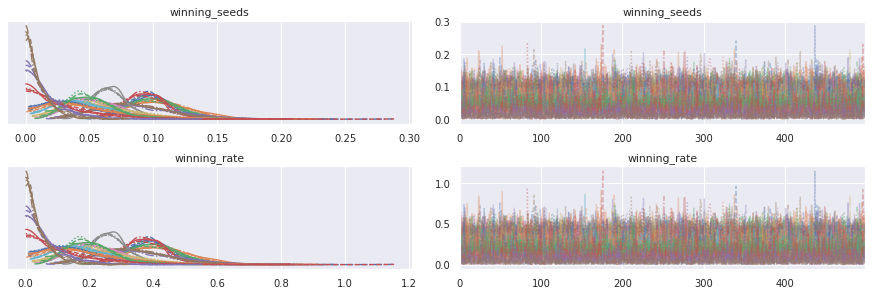

In [56]:
# モデルの実行
sm = pystan.StanModel(model_code=code)
fit = sm.sampling(data=data, iter=1000, chains=4)
print(fit)
arviz.plot_trace(fit)

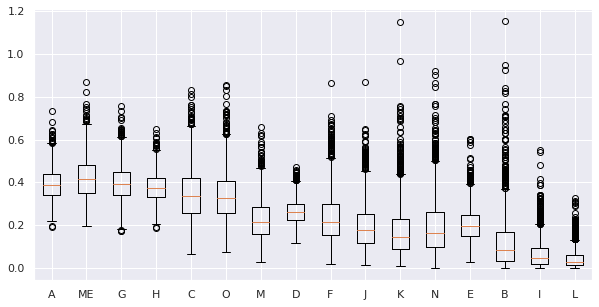

In [57]:
# プレーヤーの強さの推定結果
import seaborn as sns
results = fit.extract()
sns.set(font="IPAexGothic")
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1)
ax.boxplot(results['winning_rate'], labels = df.columns[:16])
plt.show()